In [6]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats 
%matplotlib inline

In [7]:
p = [0.5, 0.3] # p[i] = probability of earning 1 if the arm i is chosen

def reward(arm):
    return 1 if (np.random.rand() <= p[arm]) else 0


In [77]:
nbArms = 2

def UCB(T):
    rewards = np.zeros(nbArms)
    nbPlayed = np.ones(nbArms)

    rewardsTimeSeries = np.zeros((T,nbArms))
    errorRewarsTimeSeries = np.zeros((T,nbArms))
    actionsTimeSeries = np.zeros((T))

    
    for t in range(T):
        averageReward = rewards / nbPlayed
        c = np.sqrt( 2* np.log(t+1) / nbPlayed )
        if averageReward[0]+c[0]> averageReward[1]+c[1]:
            action = 0
        else:
            action = 1
        rewards[action] += reward(action)
        nbPlayed[action] += 1
        
        rewardsTimeSeries[t,:] = averageReward
        errorRewarsTimeSeries[t,:] = c
        actionsTimeSeries[t] = action

    return(rewardsTimeSeries,errorRewarsTimeSeries,actionsTimeSeries)

In [78]:
T=1000
R,E,A = UCB(T)
[print('Arm {0} was chosen {1} times'.format(i,sum(A==i))) for i in range(nbArms)]

Arm 0 was chosen 125 times
Arm 1 was chosen 875 times


[None, None]

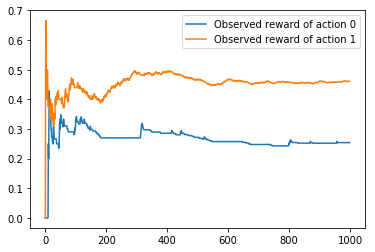

In [79]:
plt.plot(range(T),R[:,0])
plt.plot(range(T),R[:,1])
plt.legend(['Observed reward of action 0','Observed reward of action 1'])

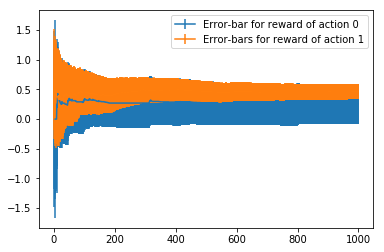

In [80]:
plt.errorbar(range(T),R[:,0],E[:,0])
plt.errorbar(range(T),R[:,1],E[:,1])
plt.legend(['Error-bar for reward of action 0','Error-bars for reward of action 1'])

## Thomson's sampling

In [81]:

def thompson(T):
    rewards = np.zeros(nbArms)
    nbPlayed = np.ones(nbArms)

    rewardsTimeSeries = np.zeros((T,nbArms))
    actionsTimeSeries = np.zeros((T))

    
    for t in range(T):
        arms = [np.random.beta(1+rewards[i],1+nbPlayed[i]) for i in [0,1]]
        if arms[0] > arms[1]:
            action = 0
        else:
            action = 1
        rewards[action] += reward(action)
        nbPlayed[action] += 1
        
        rewardsTimeSeries[t,:] = rewards/nbPlayed
        actionsTimeSeries[t] = action

    return(rewardsTimeSeries,actionsTimeSeries)

Arm 0 was chosen 44 times
Arm 1 was chosen 956 times


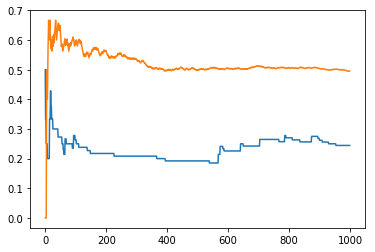

In [82]:
R,A = thompson(T)
[print('Arm {0} was chosen {1} times'.format(i,sum(A==i))) for i in range(nbArms)]
plt.plot(R)

## Bayes-UCB

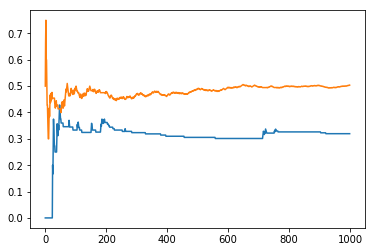

In [83]:

def bayesUCB(T):
    rewards = np.zeros(nbArms)
    nbPlayed = np.ones(nbArms)

    rewardsTimeSeries = np.zeros((T,nbArms))
    actionsTimeSeries = np.zeros((T))
    
    for t in range(T):
        arms = [scipy.stats.beta.ppf(1-1/(1+t),1+rewards[i],1+nbPlayed[i]) for i in [0,1]]
        if arms[0] > arms[1]:
            action = 0
        else:
            action = 1
        rewards[action] += reward(action)
        nbPlayed[action] += 1
        
        rewardsTimeSeries[t,:] = rewards/nbPlayed
        actionsTimeSeries[t] = action

    return(rewardsTimeSeries,actionsTimeSeries)

R,A = bayesUCB(1000)
plt.plot(R)

In [84]:
def averageRegret(policy,T,nbSamples):
    averageReward = np.zeros(T)
    bestArm = max(p)
    for i in range(nbSamples):
        actionSequence = policy(T)[-1]
        averageReward += np.array([p[int(actionSequence[i])] for i in range(T)])/nbSamples
    return( np.cumsum(bestArm - averageReward) )

UCB_reg = averageRegret(UCB,1000,100)
TS_reg = averageRegret(thompson,1000,100)
BUCB_reg = averageRegret(bayesUCB,1000,100)
    

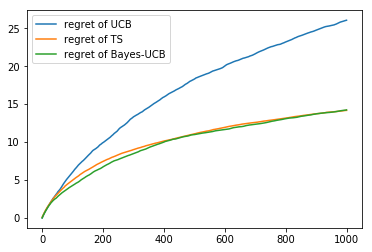

In [85]:
plt.plot(UCB_reg)
plt.plot(TS_reg)
plt.plot(BUCB_reg)
plt.legend(['regret of UCB','regret of TS','regret of Bayes-UCB'])

In [59]:
def epsilonGreedy(T,epsilon):
    rewards = np.zeros(nbArms)
    nbPlayed = np.zeros(nbArms)
    
    rewardsTimeSeries = np.zeros((T,nbArms))
    actionsTimeSeries = np.zeros((T))
    
    for t in range(T):
        if np.random.rand() <= epsilon or nbPlayed[0] == 0 or nbPlayed[1]==0:
            action = np.random.randint(2)
        else:
            if rewards[0]/nbPlayed[0] >= rewards[1]/nbPlayed[1]:
                action = 0
            else:
                action = 1
        rewards[action] += reward(action)
        nbPlayed[action] += 1
        
        rewardsTimeSeries[t,:] = rewards/nbPlayed
        actionsTimeSeries[t] = action

    return(rewardsTimeSeries,actionsTimeSeries)
#epsilonGreedy(100,0.)

In [75]:
def averageReward(policy,T,nbSamples):
    averageReward = np.zeros(T)
    bestArm = max(p)
    for i in range(nbSamples):
        actionSequence = policy(T)[-1]
        averageReward += np.array([p[int(actionSequence[i])] for i in range(T)])/nbSamples
    return( averageReward )
reg_01greedy=averageReward(lambda T: epsilonGreedy(T,0.1),1000,1000)
reg_001greedy=averageReward(lambda T: epsilonGreedy(T,0.01),1000,1000)
reg_05greedy=averageReward(lambda T: epsilonGreedy(T,0.5),1000,1000)
reg_0greedy=averageReward(lambda T: epsilonGreedy(T,0.),1000,1000)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


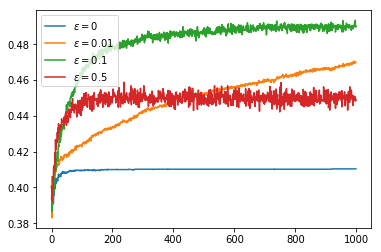

In [76]:
f = plt.figure()
plt.plot(reg_0greedy)
plt.plot(reg_001greedy)
plt.plot(reg_01greedy)
plt.plot(reg_05greedy)
plt.legend(['$\epsilon=0$','$\epsilon=0.01$','$\epsilon=0.1$','$\epsilon=0.5$'])
f.savefig('epsilon_greedy.pdf',bbox_inches='tight')

In [97]:
eps01_reg = averageRegret(lambda T: epsilonGreedy(T,0.1),1000,1000)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


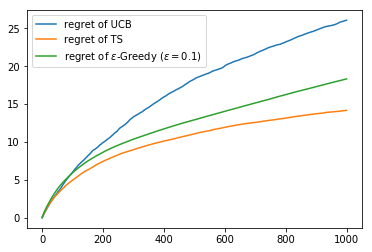

In [100]:
f = plt.figure()

plt.plot(UCB_reg)
plt.plot(TS_reg)
plt.plot(eps01_reg)
plt.legend(['regret of UCB','regret of TS','regret of $\epsilon$-Greedy ($\epsilon=0.1$)'])
f.savefig('regret_comparison_UCB_TS_epsilonGreedy.pdf',bbox_inches='tight')